In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=SyntaxWarning) 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import re

## Read meta data

In [ ]:
meta_data = pd.read_csv('../../data.nosync/phenotypic/ADHD200_phenotypic.csv')
#Expand subject ID
meta_data['ScanDir ID'] = meta_data['ScanDir ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Select columns
meta_data = meta_data[['ScanDir ID', 'Gender', 'DX']]
#Replace values
meta_data['DX'] = meta_data['DX'].replace({0: 'TD', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'})
meta_data['Gender'] = meta_data['Gender'].replace({0: 'Female', 1: 'Male'})

meta_data = meta_data.drop_duplicates('ScanDir ID')
meta_data

,ScanDir ID,Gender,DX
0,1000804,Male,TD
1,1023964,Male,ADHD-Inattentive
2,1057962,Male,ADHD-Combined
3,1099481,Female,ADHD-Combined
4,1127915,Female,TD
...,...,...,...
217,0010127,Male,ADHD-Combined
218,0010128,Male,TD
219,0010129,Female,ADHD-Inattentive
220,0010013,Male,ADHD-Combined


## Read thresholds + file list

In [ ]:
threshold_data = pd.read_csv('../../data.nosync/stats/ADHD200_17_activation_thresholds.csv', sep = ';', index_col='Unnamed: 0')
threshold_data['Subject_ID'] = threshold_data['Subject'].apply(lambda x: re.search("\d{7}", x)[0])
threshold_data['Subject_ID'] = threshold_data['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))

#Merge with meta data
threshold_data = pd.merge(left = threshold_data, 
                    right = meta_data,
                    left_on= 'Subject_ID',
                    right_on= 'ScanDir ID')
threshold_data = threshold_data.drop('ScanDir ID', axis = 1)
threshold_data

,Subject,10th,25th,50th,75th,90th,Subject_ID,Gender,DX
0,sfnwmrda3662296_session_1_rest_1,-0.475130,-0.223056,0.000132,0.237170,0.503128,3662296,Female,TD
1,sfnwmrda0010097_session_1_rest_1,-0.387366,-0.181843,0.021169,0.231994,0.444593,0010097,Female,TD
2,sfnwmrda0010064_session_1_rest_1,-0.421308,-0.188020,0.019193,0.237111,0.455676,0010064,Male,ADHD-Combined
3,sfnwmrda0010056_session_1_rest_2,-0.435537,-0.209100,0.008325,0.235567,0.474488,0010056,Male,ADHD-Inattentive
4,sfnwmrda4562206_session_1_rest_1,-0.492353,-0.235654,0.008877,0.265443,0.536959,4562206,Female,TD
...,...,...,...,...,...,...,...,...,...
389,sfnwmrda3349205_session_1_rest_1,-0.499194,-0.222867,0.038061,0.322062,0.623349,3349205,Female,ADHD-Inattentive
390,sfnwmrda2054438_session_1_rest_2,-0.678736,-0.329390,0.000314,0.332473,0.687417,2054438,Male,ADHD-Combined
391,sfnwmrda0010107_session_1_rest_1,-0.357489,-0.171575,0.001951,0.179058,0.361544,0010107,Male,ADHD-Inattentive
392,sfnwmrda1127915_session_1_rest_1,-0.462940,-0.233951,-0.011980,0.204279,0.427419,1127915,Female,TD


In [ ]:
clean_path = f'../../data.nosync/stats/ADHD200_17'
file_list = os.listdir(clean_path)
if '.DS_Store' in file_list:
    file_list.remove('.DS_Store')

# Correlation matrix

In [6]:
#Regions
num_of_regions = 17
regions = [f"ROI_{i+1}" for i in range(num_of_regions)]

thresholds = ['10th', '25th', '50th', '75th', '90th']

In [7]:
threshold_data['DX'].unique()

array(['TD', 'ADHD-Combined', 'ADHD-Inattentive',
       'ADHD-Hyperactive/Impulsive'], dtype=object)

In [ ]:
binary_data = {}

for dig in threshold_data['DX'].unique():
    binary_data[dig] = {}
    for i in thresholds:
        binary_data[dig][i] = []

    temp_threshold_data = threshold_data[threshold_data['DX'] == dig]

    #For each subject in group
    for sub in temp_threshold_data['Subject']:
        #For each threshold
        for thre in thresholds:
            #Get threshold
            threshold = float(threshold_data[threshold_data['Subject'] == sub][thre])
            #Get subject data
            subject = pd.read_csv(f'../../data.nosync/stats/ADHD200_17/{sub}.csv', sep=';', index_col='Unnamed: 0')
            for i in regions:
                subject[i] = subject[i].apply(lambda x: 1 if x >= threshold else 0)
            binary_data[dig][thre].append(subject)

    for key, value in binary_data[dig].items():
        data = pd.concat(value)
        binary_data[dig][key] = data.corr()

In [9]:
binary_data.keys()

dict_keys(['TD', 'ADHD-Combined', 'ADHD-Inattentive', 'ADHD-Hyperactive/Impulsive'])

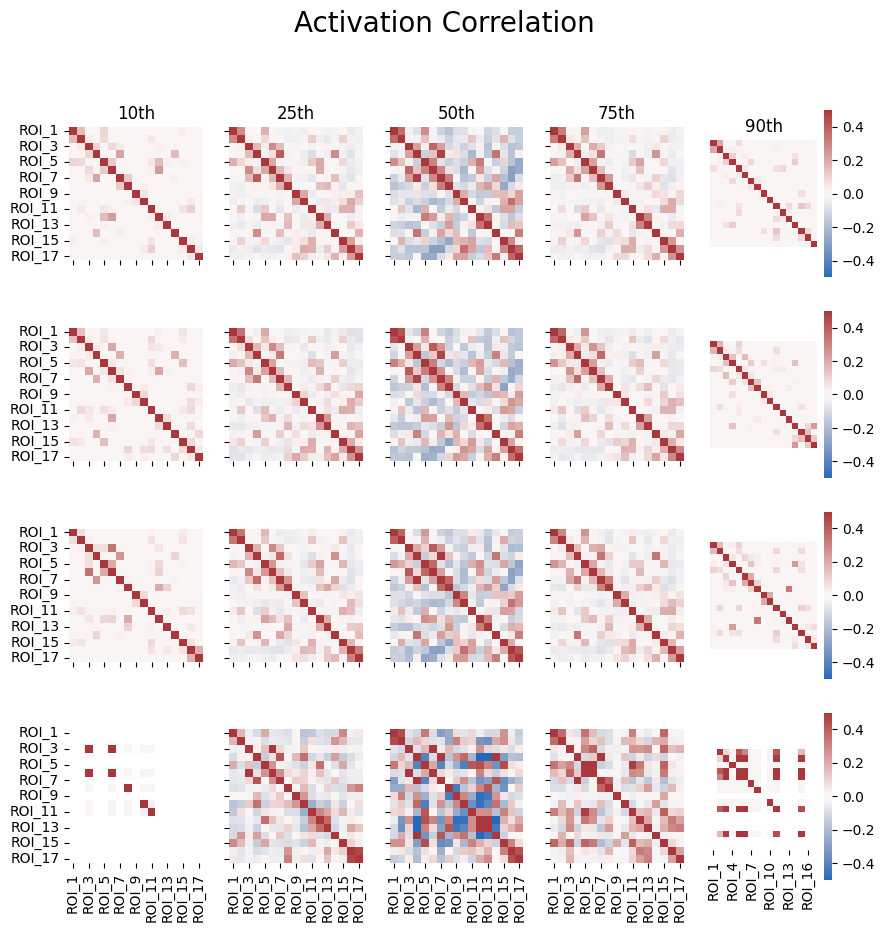

In [12]:
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
fig.suptitle('Activation Correlation', fontsize = 20)

axs_col = 0
axs_row = 0

global_min = []
global_max = []

color_map = sns.color_palette("Blues", as_cmap=True)

#Get min and max for color scale
for key, value in binary_data.items():
    #For each threshold
    for thres, corr in value.items():
        #Remove nans and get axis max
        a = corr.to_numpy().flatten()
        a = a[~np.isnan(a)]
        a = a[np.logical_not(a==1.0)]
        x_min, x_max = float(min(a)), float(max(a))
        global_min.append(x_min)
        global_max.append(x_max)


for dig in binary_data.keys():

    for key, value in binary_data[dig].items(): 
        cbar_add = True if key == '90th' else False
        
        if key == '10th':
            axs[axs_row, axs_col].set_ylabel(key)
            
        sns.heatmap(value, 
                    square = True, 
                    ax = axs[axs_row, axs_col],
                    vmax = 0.5,
                    vmin = -0.5,
                    cbar = cbar_add,
                    cmap= 'vlag')

        #Set title if first row
        if axs_row == 0:
            axs[axs_row, axs_col].set_title(key)
        
        #Remove labels ect from the fourth column
        if axs_col == 4:
            axs[axs_row, 4].axes.get_yaxis().set_visible(False)
            if axs_row != 3:
                axs[axs_row, 4].axes.get_xaxis().set_visible(False)

        #Move to left
        axs_col = axs_col + 1 if axs_col != 4 else 0
    axs_row += 1

for ax in axs.flat:
        ax.label_outer()

In [11]:
binary_data.keys()

dict_keys(['TD', 'ADHD-Combined', 'ADHD-Inattentive', 'ADHD-Hyperactive/Impulsive'])